In [1]:
import haiku as hk
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

## Get Data

In [2]:
import torch 
import torchvision
from torchvision import transforms
import torchaudio
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [3]:
def generate_PhaseMNIST(mnist_path):
    
    mnist_train_ds = torchvision.datasets.MNIST(root=mnist_path, train=True, download=False)
    mnist_test_ds = torchvision.datasets.MNIST(root=mnist_path, train=False, download=False)
    
    phasemnist_data = []
    phasemnist_labels = []
    
    for dataset in [mnist_train_ds, mnist_test_ds]:
        
        for label in tqdm(range(10)):
            
            # Get targets pairs (such that real_target + imag_target = 9)
            real_targets_idxs = (dataset.targets == label)
            imag_targets_idxs = (dataset.targets == (9-label))
    
            real_samples = dataset.data[real_targets_idxs]
            imag_samples = dataset.data[imag_targets_idxs]
            
            # Get len(real) random samples from the imaginary dataset
            imag_mask = np.random.randint(low=0, high=len(imag_samples), size=len(real_samples))
    
            # Construct the PhaseMNIST samples
            phasemnist_samples = np.asarray(real_samples) / 255. + 1.j*np.array(imag_samples[imag_mask]) / 255.
            
            phasemnist_data.append(phasemnist_samples)
            phasemnist_labels.append(np.full(len(phasemnist_samples), label))

    phasemnist_data_array = np.concatenate(phasemnist_data)
    phasemnist_labels_array = np.concatenate(phasemnist_labels)
    
    # Shuffle the two arrays
    perm = np.random.permutation(len(phasemnist_labels_array))
    phasemnist_data_array = phasemnist_data_array[perm]
    phasemnist_labels_array = phasemnist_labels_array[perm]
        
    with open(mnist_path + 'PhaseMNIST/data.npy', 'wb') as f:
        np.save(f, phasemnist_data_array)
    
    with open(mnist_path + 'PhaseMNIST/labels.npy', 'wb') as f:
        np.save(f, phasemnist_labels_array)
            
    return phasemnist_data_array, phasemnist_labels_array

In [4]:
class PhaseMNIST(Dataset):
    
    def __init__(self, path, transform=None):
        
        with open(path + 'data.npy', 'rb') as f:
            self.data = np.load(f)
            
        with open(path + 'labels.npy', 'rb') as f:
            self.labels = np.load(f)
        
        self.length = len(self.labels)
        self.transform = transform
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        
        sample = (self.data[index], self.labels[index])
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

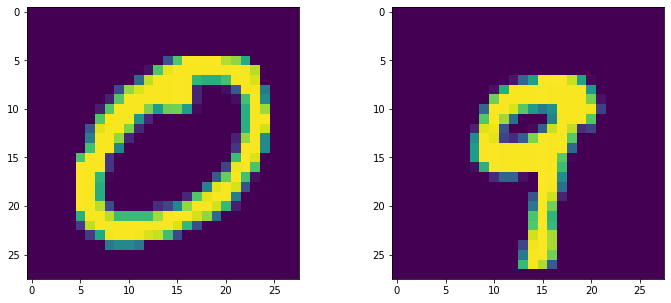

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].imshow(PhaseMNIST('data/PhaseMNIST/')[0][0].real)
ax[1].imshow(PhaseMNIST('data/PhaseMNIST/')[0][0].imag)

In [5]:
class ToTensor_onehot(object):
    """Convert sample to Tensors and one-hot encode the labels."""
    def __init__(self, n_classes=2):
        self.n_classes = n_classes

    def __call__(self, sample):
        x, y = sample
        # One-hot encoding
        y = np.eye(self.n_classes)[y]
        return ( torch.from_numpy(x), torch.tensor([y]) )
    
class Squeeze(object):
    """Remove the extra dimensions of the tensors."""
    def __init__(self, squeeze_x=True, squeeze_y=True):
        self.squeeze_x = squeeze_x
        self.squeeze_y = squeeze_y
    
    def __call__(self, sample):
        x, y = sample
        if self.squeeze_x:
            x = torch.squeeze(x)
        if self.squeeze_y:
            y = torch.squeeze(y)
        return ( x, y )

In [6]:
def build_dataloaders(data_dir, composed_transform, drop_length=0, batch_size=32):
    
    full_dataset = PhaseMNIST(path=data_dir, transform=composed_transform)
    
    train_len = int(0.75 * (len(full_dataset)-drop_length))
    test_len = len(full_dataset) - train_len - drop_length
    train_ds, test_ds, _ = torch.utils.data.random_split(full_dataset, [train_len, test_len, drop_length])
    
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, test_dataloader

In [32]:
mnist_path = 'data/PhaseMNIST/'
batch_size = 64
drop_length = 50000
data_transform = transforms.Compose([ToTensor_onehot(n_classes=10), Squeeze(squeeze_x=False)])

In [33]:
train_dl, test_dl = build_dataloaders(mnist_path, data_transform, drop_length, batch_size=batch_size)

batch_sample = next(iter(test_dl))
print('Data shapes:\n x-> {} y-> {}'.format(batch_sample[0].shape, batch_sample[1].shape))
print('\nNumber of samples in the datasets: \n  Training set: {0} \n  Test set: {1}'.format(len(train_dl)*batch_size, len(test_dl)*batch_size))

Data shapes:
 x-> torch.Size([64, 28, 28]) y-> torch.Size([64, 10])

Number of samples in the datasets: 
  Training set: 15040 
  Test set: 5056


In [1]:
class ESC10_DataGenerator(Dataset):
    
    def __init__(self, path, kind='train', transform=None):
        
        if kind=='train':
            files = Path(path).glob('[1-4]-*')
        if kind=='test':
            files = Path(path).glob('[5]-*')
        
        self.items = [(str(file), file.name.split('-')[-1].replace('.wav', '')) for file in files]
        self.length = len(self.items)
        self.transform = transform
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        data_tensor, rate = torchaudio.load(filename)
        
        sample = (data_tensor.numpy(), int(label))
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

NameError: name 'Dataset' is not defined

In [ ]:
class ToTensor_onehot(object):
    """Convert sample to Tensors."""
    def __init__(self, n_classes=2):
        self.n_classes = n_classes

    def __call__(self, sample):
        x, y = sample
        # Convert from ESC50 to ESC10
        y = y // 5
        # One-hot encoding
        y = np.eye(self.n_classes)[y]
        return ( torch.from_numpy(x), torch.tensor([y]) )
    
class Compute_FFT(object):
    def __call__(self, sample):
        x, y = sample
        fft = torch.fft.fft(x.flatten(), norm='forward')
        return (fft, y)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

esc_path = 'data/ESC-50-master/audio/'

wave = torch.tensor(ESC10_DataGenerator(path = esc_path, kind = 'train')[0][0])
ax[0].plot(wave.flatten())
ax[1].plot(torch.nn.functional.avg_pool1d(wave.unsqueeze(0), kernel_size=3, stride=8).flatten())

In [ ]:
def build_dataloaders(data_dir, composed_transform, batch_size=32):
    
    train_dataloader = DataLoader(ESC10_DataGenerator(path = data_dir,
                                                      kind = 'train',
                                                      transform=composed_transform),
                                  batch_size=batch_size, shuffle=True)

    test_dataloader = DataLoader(ESC10_DataGenerator(path = data_dir,
                                                      kind = 'test',
                                                      transform=composed_transform),
                                  batch_size=batch_size, shuffle=True)
    
    return train_dataloader, test_dataloader

In [ ]:
esc_path = 'data/ESC-50-master/audio/'
batch_size = 64
data_transform = transforms.Compose([ToTensor_onehot(n_classes=10), Squeeze(), Compute_FFT()])

In [ ]:
train_dl, test_dl = build_dataloaders(esc_path, data_transform, batch_size=batch_size)

batch_sample = next(iter(train_dl))
print('Data shapes:\n x-> {} y-> {}'.format(batch_sample[0].shape, batch_sample[1].shape))
print('\nNumber of samples in the datasets: \n  Training set: {0} \n  Test set: {1}'.format(len(train_dl)*batch_size, len(test_dl)*batch_size))

In [54]:
from complex_nn.dummy import CmplxBatchNorm
from complex_nn.layers import Cmplx_Normalization

In [61]:
class ComplexMLP(hk.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = Cmplx_Linear(64)
        self.fc2 = Cmplx_Linear(32)
        self.fc3 = Cmplx_Linear(10)
        
        self.batchnorm_2D = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NCHW')
        self.batchnorm_1D = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.5, data_format='NC')
        self.norm = Cmplx_Normalization()
        self.dropout = Dropout(0.3)
        self.flatten = hk.Flatten()
        
        
        self.act = cardioid
        
    def __call__(self, z, is_training):
        z = self.flatten(z)
        z = self.act(self.fc1(z))
        z = self.norm(z)
        z = self.dropout(z)
        z = self.act(self.fc2(z))
        z = self.fc3(z)
        return z

In [56]:
from complex_nn.optimizers import cmplx_adam
from complex_nn.layers import Cmplx_Linear, Dropout
from complex_nn.activations import cardioid

In [57]:
from complex_nn import Classifier_wrapper 
reload(Classifier_wrapper)
from complex_nn.Classifier_wrapper import Haiku_Classifier
from complex_nn.utils import small_training_summary

In [118]:
from complex_nn import layers
reload(layers)
from complex_nn.layers import Cmplx_Normalization

In [119]:
HC = Haiku_Classifier()
_ = HC.train(n_epochs = 50, 
             model = ComplexMLP, 
             optimizer = cmplx_adam(step_size=1e-2),  
             train_dataloader = train_dl,
             test_dataloader = test_dl,
             verbose = False
            )         

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/235 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

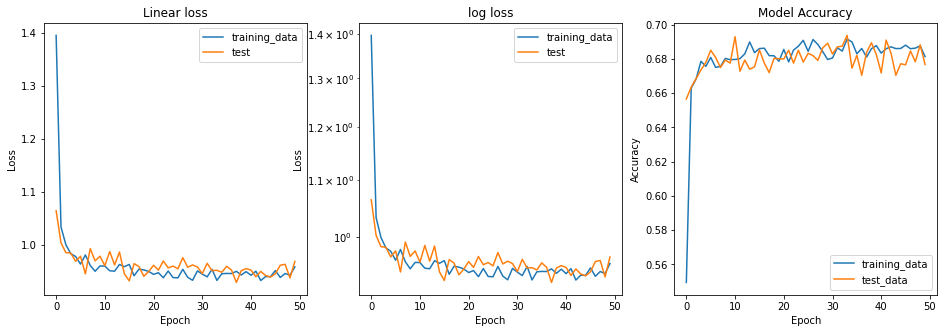

In [120]:
small_training_summary(HC.training_history)

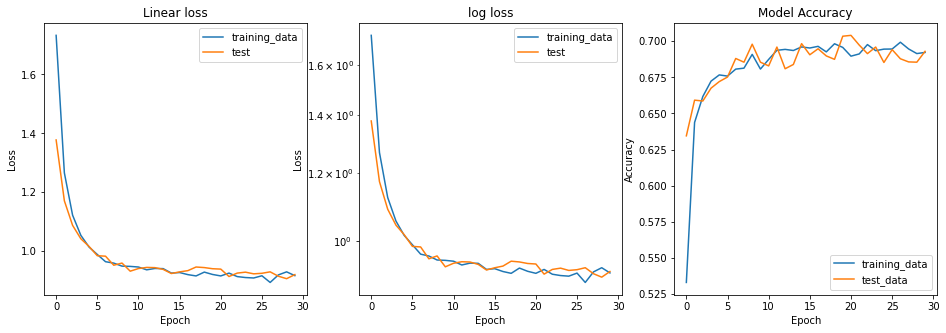

In [38]:
small_training_summary(HC.training_history)

In [ ]:
from complex_nn.layers import Cmplx_Linear, Dropout
from complex_nn.activations import cardioid
from complex_nn.haiku_ml_utils import initialize_cmplx_haiku_model
from complex_nn.initializers import Cmplx_Xavier_Init, Cmplx_He_Init
from complex_nn.utils import small_training_summary
from complex_nn.metrics import categorical_accuracy

In [ ]:
from complex_nn import metrics
reload(metrics)
from complex_nn.metrics import categorical_accuracy

In [3]:
from complex_nn.Classifier_wrapper import Haiku_Classifier
from complex_nn.optimizers import cmplx_adam
import jax
import jax.numpy as jnp

In [4]:
model, params, state = initialize_cmplx_haiku_model(ComplexMLP, init_shape=(64,784))

NameError: name 'initialize_cmplx_haiku_model' is not defined

In [ ]:
dummy_batch = next(iter(test_dl))

In [ ]:
categorical_accuracy(model, params, dummy_batch[0][0].unsqueeze(0).numpy(), dummy_batch[1][0].reshape(1,-1).numpy(), jax.random.PRNGKey(0), state)

In [ ]:
hc = Haiku_Classifier(rng_seed=42, with_state=True)
_ = hc.train(n_epochs = 2, 
             model = ComplexMLP, 
             optimizer = cmplx_adam(step_size=1e-3),  
             train_dataloader = train_dl,
             test_dataloader = test_dl,
             verbose = False)

small_training_summary(hc.training_history)

In [ ]:
class TwoCH_MLP(hk.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1_r = hk.Linear(5)
        self.fc2_r = hk.Linear(16)
        
        self.fc1_i = hk.Linear(5)
        self.fc2_i = hk.Linear(16)
        
        self.fc3 = hk.Linear(10)
        
        self.dropout = Dropout(0.3)
        self.flatten = hk.Flatten()
        
        self.act = jax.nn.relu
        
    def __call__(self, z, is_training):
        
        z = self.flatten(z)
        x = z.real
        y = z.imag
        
        x = self.act(self.fc1_r(x))
        x = self.dropout(x)
        #x = self.act(self.fc2_r(x))
        
        y = self.act(self.fc1_i(y))
        y = self.dropout(y)
        #y = self.act(self.fc2_i(y))
        
        xy = jnp.concatenate([x,y], axis=-1)
        out = self.fc3(xy)
        
        return out

In [ ]:
hc2ch = Haiku_Classifier(rng_seed=42, with_state=True)
_ = hc2ch.train(n_epochs = 1000, 
             model = TwoCH_MLP, 
             optimizer = cmplx_adam(step_size=1e-2),  
             train_dataloader = train_dl,
             test_dataloader = test_dl,
             verbose = False)

small_training_summary(hc2ch.training_history)

In [ ]:
import complex_nn
reload(complex_nn)
from complex_nn.utils import small_training_summary

Test to do:
* different weights initializations
* real vs complex vs 2-channels
* real vs complex with and without regularization
* test different activations